<>:120: SyntaxWarning: invalid escape sequence '\P'
<>:120: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Y.A\AppData\Local\Temp\ipykernel_19584\3462921566.py:120: SyntaxWarning: invalid escape sequence '\P'
  plt.title(f"Distribution of $\Phi$ in {city}")


--------- City:  Budapest, Hungary


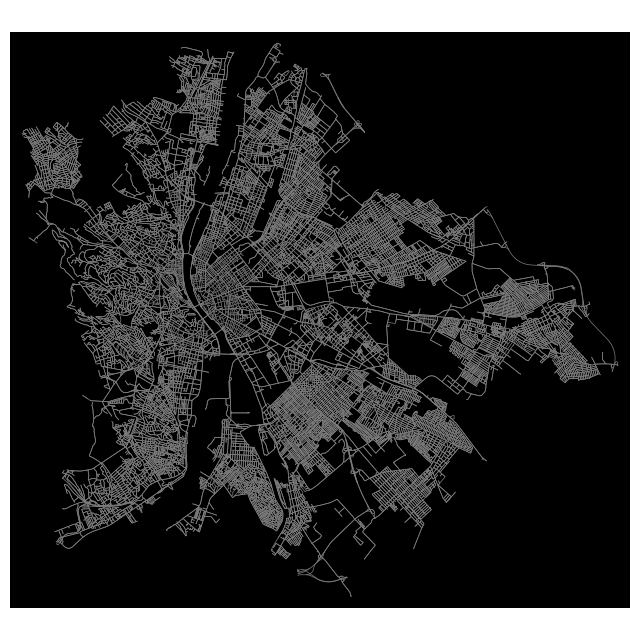

Number of faces in Budapest, Hungary: 11986


Processing faces for Budapest, Hungary: 100%|██████████| 11986/11986 [00:06<00:00, 1991.28it/s]


Budapest, Hungary - Mean Φ: 0.3927, Median Φ: 0.4040, Std Φ: 0.1557


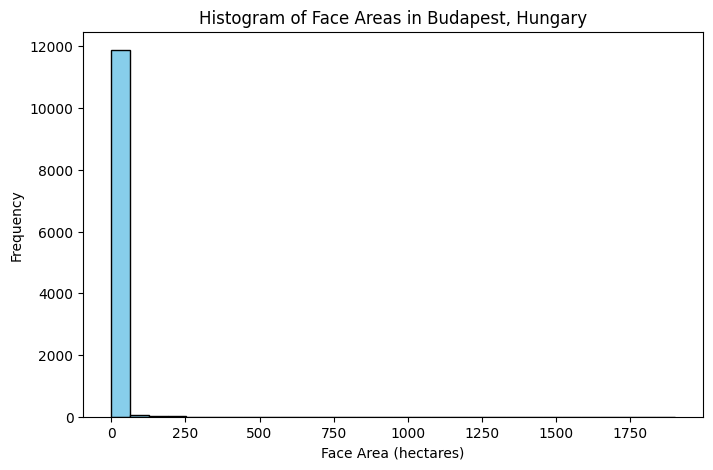

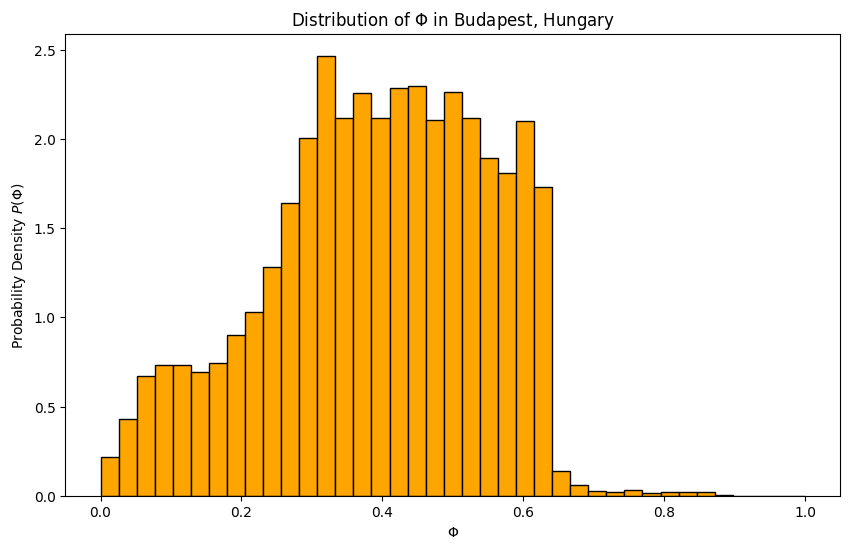

,mean,median,std
"Budapest, Hungary",0.392735,0.404047,0.15567


C:\Users\Y.A\AppData\Local\Temp\ipykernel_19584\3462921566.py:132: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(phi_data, labels=cities, patch_artist=True, showmeans=True, meanline=True)


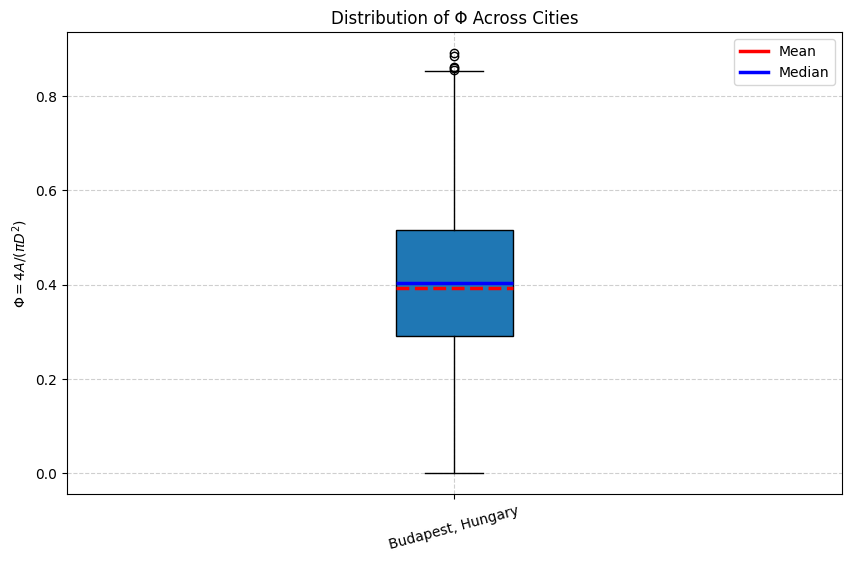

Budapest, Hungary: Mean Phi = 0.393, Phi Std = 0.156, Phi Median = 0.404
Budapest, Hungary: Phi Mode = 0.448

Budapest, Hungary additional statistics:
IQR = 0.225
MAD = 0.128

=== FACE AREA STATISTICS (square meters) ===

Budapest, Hungary face area statistics:
Number of faces: 11986
Mode = 300.0 m²
Mean = 65252.0 m²
Median = 30870.6 m²
Std = 364893.4 m²
MAD = 65812.0 m²
IQR = 39568.5 m²


In [1]:
# Unified City Block Shape Analysis
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize
import numpy as np
from tqdm import tqdm
import random
import math
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
from IPython.display import display
import matplotlib.lines as mlines
import scipy.stats

# List of cities to analyze
cities = ['Budapest, Hungary']

# Initialize storage variables
phi_values = []  # Store mean Phi values per city
phi_means = []  # Store mean Phi values per city
phi_stds = []  # Store standard deviation per city
phi_statistics = {}  # Dictionary to store mean, median, and std for each city
phi_distributions = {}  # Dictionary to store distributions for box plot
all_faces = {}  # Store extracted faces per city
all_face_areas = {}  # Store face areas per city

for city in cities:
    print('--------- City: ', city)

    # Download road network based on city
    if city == "Paris, France":
        G = ox.graph_from_place("Le Marais, Paris, France", network_type="drive")
    elif city == "Tel Aviv, Israel":
        G = ox.graph_from_bbox(32.1, 32.05, 34.8, 34.75, network_type="drive")
    elif city == "Kyoto, Japan":
        north, south = 35.008609, 34.998609
        east, west = 135.781183, 135.771183
        G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
    elif city == "manSeg, NY":
        G = ox.graph_from_point((40.77892619481051, -73.9510420715686), 300, network_type="drive")
    else:
        G = ox.graph_from_place(city, network_type="drive")

    # Plot the road network
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor('black')
    ox.plot_graph(G, ax=ax, node_size=0, edge_color='gray', edge_linewidth=0.5, show=False)
    plt.title(f"Road Network of {city}", color='white')
    plt.show()
    
    # Convert graph to undirected and extract edges as LineStrings
    G_undirected = nx.Graph(G)
    gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
    gdf_edges = gdf_edges.to_crs(epsg=3857)  # Convert to metric projection
    
    # Create a list of LineStrings representing the street edges
    edge_lines = [LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])]) for u, v in G_undirected.edges()]
    
    # Extract the enclosed faces using polygonization
    faces = list(polygonize(edge_lines))
    faces = gpd.GeoSeries(faces, crs='EPSG:4326').to_crs(epsg=3857)  # Convert polygons to metric projection
    all_faces[city] = faces  # Store faces per city
    
    city_phi_values = []  # Store Phi values for the current city
    face_areas = []  # Store block areas for the current city
    
    print(f"Number of faces in {city}: {len(faces)}")
    
    # Process each polygon
    for polygon in tqdm(faces, desc=f"Processing faces for {city}"):
        A = polygon.area  # Block area
        face_areas.append(A / 10000)  # Convert m² to hectares
        
        # Compute the largest internal distance (D)
        coords = list(polygon.exterior.coords)
        max_dist = 0
        for i, p1 in enumerate(coords):
            for p2 in coords[i+1:]:
                dist = np.linalg.norm(np.array(p1) - np.array(p2))
                max_dist = max(max_dist, dist)
        D = max_dist  # Maximum distance
        
        if D > 0:
            phi = 4 * A / (np.pi * D**2)
            city_phi_values.append(phi)
    
    # Calculate statistics
    phi_mean = np.mean(city_phi_values) if city_phi_values else 0
    phi_median = np.median(city_phi_values) if city_phi_values else 0
    phi_std = np.std(city_phi_values, ddof=1) if len(city_phi_values) > 1 else 0
    
    # Store the computed values
    phi_means.append(phi_mean)
    phi_stds.append(phi_std)
    phi_values.append(city_phi_values if city_phi_values else [])
    phi_statistics[city] = {'mean': phi_mean, 'median': phi_median, 'std': phi_std}
    phi_distributions[city] = city_phi_values.copy()
    all_face_areas[city] = face_areas
    
    print(f"{city} - Mean Φ: {phi_mean:.4f}, Median Φ: {phi_median:.4f}, Std Φ: {phi_std:.4f}")
    
    # Plot histogram of face areas
    plt.figure(figsize=(8, 5))
    plt.hist(face_areas, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("Face Area (hectares)")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Face Areas in {city}")
    plt.show()

    # Plot distribution of phi P(phi)
    plt.figure(figsize=(10, 6))
    bins = np.linspace(0, 1, 40)
    plt.hist(city_phi_values, bins=bins, color='orange', edgecolor='black', density=True)
    plt.xlabel(r"$\Phi$")
    plt.ylabel(r"Probability Density $P(\Phi)$")
    plt.title(f"Distribution of $\Phi$ in {city}")
    plt.show()

# Display final statistics as DataFrame
phi_df = pd.DataFrame.from_dict(phi_statistics, orient='index')
display(phi_df)

# Ensure all phi values are valid lists
phi_data = [phi_distributions[city] if isinstance(phi_distributions[city], list) and phi_distributions[city] else [np.nan] for city in cities]

# Box plot for phi distributions
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(phi_data, labels=cities, patch_artist=True, showmeans=True, meanline=True)

# Adjust line width for median and mean
line_width = 2.5
for line in boxplot['medians']:
    line.set(linewidth=line_width, color='blue')  # Set the median line width
for line in boxplot['means']:
    line.set(linewidth=line_width, color='red')   # Set the mean line width

plt.ylabel(r"$Φ = 4A / (πD^2)$")
plt.title("Distribution of Φ Across Cities")
plt.xticks(rotation=15)
plt.grid(True, linestyle='--', alpha=0.6)

# Adding legend for mean and median
mean_line = mlines.Line2D([], [], color='red', linestyle='-', label='Mean', linewidth=line_width)
median_line = mlines.Line2D([], [], color='blue', linestyle='-', label='Median', linewidth=line_width)
plt.legend(handles=[mean_line, median_line], loc='upper right')
plt.show()

# Print summary statistics
for city, mean, std in zip(cities, phi_means, phi_stds):
    print(f"{city}: Mean Phi = {mean:.3f}, Phi Std = {std:.3f}, Phi Median = {np.median(phi_values[cities.index(city)]):.3f}")

# Calculate and print mode for each city
for city, phi_list in zip(cities, phi_values):
    rounded_values = np.round(phi_list, decimals=3)
    mode_result = scipy.stats.mode(rounded_values)
    mode_value = float(mode_result.mode)
    print(f"{city}: Phi Mode = {mode_value:.3f}")

# Print IQR and MAD for phi values
for city, phi_list in zip(cities, phi_values):
    phi_array = np.array(phi_list)
    q1 = np.percentile(phi_array, 25)
    q3 = np.percentile(phi_array, 75)
    iqr = q3 - q1
    mad = np.mean(np.abs(phi_array - np.mean(phi_array)))
    print(f"\n{city} additional statistics:")
    print(f"IQR = {iqr:.3f}")
    print(f"MAD = {mad:.3f}")

# Print face area summary statistics
print("\n=== FACE AREA STATISTICS (square meters) ===")
for city, areas in all_face_areas.items():
    areas_m2 = np.array(areas) * 10000
    mean_area = np.mean(areas_m2)
    median_area = np.median(areas_m2)
    std_area = np.std(areas_m2)
    mad_area = np.mean(np.abs(areas_m2 - mean_area))
    q1_area = np.percentile(areas_m2, 25)
    q3_area = np.percentile(areas_m2, 75)
    iqr_area = q3_area - q1_area
    rounded_areas = np.round(areas_m2, -2)
    mode_result = scipy.stats.mode(rounded_areas)
    mode_area = float(mode_result.mode)
    
    print(f"\n{city} face area statistics:")
    print(f"Number of faces: {len(areas_m2)}")
    print(f"Mode = {mode_area:.1f} m²")
    print(f"Mean = {mean_area:.1f} m²")
    print(f"Median = {median_area:.1f} m²")
    print(f"Std = {std_area:.1f} m²")
    print(f"MAD = {mad_area:.1f} m²")
    print(f"IQR = {iqr_area:.1f} m²")

In [ ]:
 # Print all phi values
print("=== ALL PHI VALUES ===")
for city, phi_list in zip(cities, phi_values):
    print(f"\nPhi values for {city}:")
    print(f"Number of values: {len(phi_list)}")
    sorted_values = sorted(phi_list)
    print("Values:", [f"{x:.3f}" for x in sorted_values])

# Print all face areas
print("\n=== ALL FACE AREAS (square meters) ===")
for city, areas in all_face_areas.items():
    areas_m2 = np.array(areas) * 10000
    print(f"\n{city} all face areas:")
    print(f"Number of faces: {len(areas_m2)}")
    print("Areas (m²):")
    print('\n'.join([f"{x:.1f}" for x in sorted(areas_m2)]))

In [ ]:
# Unified Polygon Analysis
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize
import numpy as np
from tqdm import tqdm
import scipy.stats
import pandas as pd
from IPython.display import display
import matplotlib.lines as mlines

# Define the polygon for Brussels
Dhaka_Center_Core_Polygon = Polygon([
    (90.35309257171741, 23.799539446866742),
    (90.36905220880124, 23.807989335735403),
    (90.37618138682285, 23.80621045736624),
    (90.38752326089332, 23.799094700618273),
    (90.3914119034493, 23.783379356937964),
    (90.36172755825764, 23.777195361973877),
    (90.34665562098688, 23.7826118774426),
    (90.35309257171741, 23.799539446866742),
])

# Initialize storage variables
phi_values = []
all_face_areas = {}
phi_statistics = {}
city = "Dhaka Center"

# Extract road network from the polygon
G = ox.graph_from_polygon(Dhaka_Center_Core_Polygon, network_type="drive")
print("--------- City:", city)

# Plot the road network
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('black')
ox.plot_graph(G, ax=ax, node_size=0, edge_color='gray', edge_linewidth=0.5, show=False)
plt.title(f"Road Network of {city}", color='white')
plt.show()

# Convert graph to undirected and extract edges
G_undirected = nx.Graph(G)
gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
gdf_edges = gdf_edges.to_crs(epsg=3857)  # Convert to metric projection

# Create a list of LineStrings representing the street edges
edge_lines = [LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])]) for u, v in G_undirected.edges()]

# Extract the enclosed faces using polygonization
faces = list(polygonize(edge_lines))
faces = gpd.GeoSeries(faces, crs='EPSG:4326').to_crs(epsg=3857)  # Convert polygons to metric projection

city_phi_values = []  # Store Phi values for the current city
face_areas = []  # Store block areas for the current city

print(f"Number of faces in {city}: {len(faces)}")

# Process each polygon
for polygon in tqdm(faces, desc=f"Processing faces for {city}"):
    A = polygon.area  # Block area
    face_areas.append(A / 10000)  # Convert m² to hectares

    # Compute the largest internal distance (D)
    coords = list(polygon.exterior.coords)
    max_dist = 0
    for i, p1 in enumerate(coords):
        for p2 in coords[i+1:]:
            dist = np.linalg.norm(np.array(p1) - np.array(p2))
            max_dist = max(max_dist, dist)
    D = max_dist  # Maximum distance

    if D > 0:
        phi = 4 * A / (np.pi * D**2)
        city_phi_values.append(phi)

# Calculate statistics
phi_mean = np.mean(city_phi_values) if city_phi_values else 0
phi_median = np.median(city_phi_values) if city_phi_values else 0
phi_std = np.std(city_phi_values, ddof=1) if len(city_phi_values) > 1 else 0
phi_statistics[city] = {'mean': phi_mean, 'median': phi_median, 'std': phi_std}
all_face_areas[city] = face_areas

# Print basic statistics
print(f"{city}: Mean Phi = {phi_mean:.3f}, Phi Std = {phi_std:.3f}, Phi Median = {phi_median:.3f}")

# Calculate and print mode
rounded_values = np.round(city_phi_values, decimals=3)
mode_result = scipy.stats.mode(rounded_values)
mode_value = float(mode_result.mode)
print(f"{city}: Phi Mode = {mode_value:.3f}")

# Calculate and print IQR and MAD
phi_array = np.array(city_phi_values)
q1 = np.percentile(phi_array, 25)
q3 = np.percentile(phi_array, 75)
iqr = q3 - q1
mad = np.mean(np.abs(phi_array - np.mean(phi_array)))
print(f"\n{city} additional statistics:")
print(f"IQR = {iqr:.3f}")
print(f"MAD = {mad:.3f}")

# Display statistics as DataFrame
phi_df = pd.DataFrame.from_dict(phi_statistics, orient='index')
display(phi_df)

# Plot histogram of face areas
plt.figure(figsize=(8, 5))
plt.hist(face_areas, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Face Area (hectares)")
plt.ylabel("Frequency")
plt.title(f"Histogram of Face Areas in {city}")
plt.show()

# Plot distribution of phi P(phi)
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 40)
plt.hist(city_phi_values, bins=bins, color='orange', edgecolor='black', density=True)
plt.xlabel(r"$\Phi$")
plt.ylabel(r"Probability Density $P(\Phi)$")
plt.title(f"Distribution of $\Phi$ in {city}")
plt.show()

# Box plot for phi distribution
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot([city_phi_values], labels=[city], patch_artist=True, showmeans=True, meanline=True)

# Adjust line width for median and mean
line_width = 2.5
for line in boxplot['medians']:
    line.set(linewidth=line_width, color='blue')  # Set the median line width
for line in boxplot['means']:
    line.set(linewidth=line_width, color='red')   # Set the mean line width

plt.ylabel(r"$Φ = 4A / (πD^2)$")
plt.title(f"Distribution of Φ in {city}")
plt.grid(True, linestyle='--', alpha=0.6)

# Adding legend for mean and median
mean_line = mlines.Line2D([], [], color='red', linestyle='-', label='Mean', linewidth=line_width)
median_line = mlines.Line2D([], [], color='blue', linestyle='-', label='Median', linewidth=line_width)
plt.legend(handles=[mean_line, median_line], loc='upper right')
plt.show()

# Print face area summary statistics
print("\n=== FACE AREA STATISTICS (square meters) ===")
areas_m2 = np.array(face_areas) * 10000
mean_area = np.mean(areas_m2)
median_area = np.median(areas_m2)
std_area = np.std(areas_m2)
mad_area = np.mean(np.abs(areas_m2 - mean_area))
q1_area = np.percentile(areas_m2, 25)
q3_area = np.percentile(areas_m2, 75)
iqr_area = q3_area - q1_area
rounded_areas = np.round(areas_m2, -2)
mode_result = scipy.stats.mode(rounded_areas)
mode_area = float(mode_result.mode)

print(f"\n{city} face area statistics:")
print(f"Number of faces: {len(areas_m2)}")
print(f"Mode = {mode_area:.1f} m²")
print(f"Mean = {mean_area:.1f} m²")
print(f"Median = {median_area:.1f} m²")
print(f"Std = {std_area:.1f} m²")
print(f"MAD = {mad_area:.1f} m²")
print(f"IQR = {iqr_area:.1f} m²")